https://www.kaggle.com/crowdflower/twitter-airline-sentiment

#### Import modules

In [1]:
%matplotlib inline

In [3]:
try:
    from IPython.display import display
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import os, sys, re
    from tqdm import tqdm_notebook

    import scipy
    from scipy import stats
    import statsmodels.api as sm
    from afinn import Afinn
except:
    !pip install -r requirements.txt > /dev/null
    !python -m nltk.downloader stopwords /dev/null

# 1. Exploratory data analysis

In [3]:
tweets=pd.read_csv(os.path.join(os.getcwd(),'Tweets.csv'))

In [4]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
n=tweets.shape[0]
tweets.shape

(14640, 15)

#### Data at a glance

In the dataset we have in total 14640 rows of data with 15 columns. 

<br>
Our target is to predict airline_sentiment. The other potentialy helpful columns are: <br>
airline_sentiment_confidence,<br>
negativereason, <br>
negativereason_confidence, <br>
airline_sentiment_gold, <br>
negativereason_gold <br>

<br>
For every tweet, there are 9 features: tweet_id, airline, name, retweet_count, text, tweet_coord, tweet_created, tweet_location and user_timezone. <br>
Column tweet_id, name and tweet_created (timestamp) are uniq for each tweet. <br>
Column retweet_count is numeric. <br>
The others can be treated as categorical.

Since the tweet_id and name are uniq for each tweet and they'll not be used for analysis, I first remove the two columns

In [6]:
tweets=tweets.drop(columns=['tweet_id', 'name'])

In [7]:
tweets.describe(include='all')

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
count,14640,14640.000000,9178,10522.000000,14640,40,32,14640.000000,14640,1019,14640,9907,9820
unique,3,NaN,10,NaN,6,3,13,NaN,14427,832,14247,3081,85
top,negative,NaN,Customer Service Issue,NaN,United,negative,Customer Service Issue,NaN,@united thanks,"[0.0, 0.0]",2015-02-24 09:54:34 -0800,"Boston, MA",Eastern Time (US & Canada)
freq,9178,NaN,2910,NaN,3822,32,12,NaN,6,164,5,157,3744
mean,NaN,0.900169,NaN,0.638298,NaN,NaN,NaN,0.082650,NaN,NaN,NaN,NaN,NaN
std,NaN,0.162830,NaN,0.330440,NaN,NaN,NaN,0.745778,NaN,NaN,NaN,NaN,NaN
min,NaN,0.335000,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,0.692300,NaN,0.360600,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,1.000000,NaN,0.670600,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN


In [8]:
labels=['positive', 'neutral', 'negative']

## 1.1 Check the missing data rate

The first 8 columns have no missing data

In [9]:
((len(tweets)-tweets.count())/len(tweets)).sort_values()

airline_sentiment               0.000000
airline_sentiment_confidence    0.000000
airline                         0.000000
retweet_count                   0.000000
text                            0.000000
tweet_created                   0.000000
negativereason_confidence       0.281284
tweet_location                  0.323292
user_timezone                   0.329235
negativereason                  0.373087
tweet_coord                     0.930396
airline_sentiment_gold          0.997268
negativereason_gold             0.997814
dtype: float64

### 1.1.1 Explore the columns having top 3 missing rate

The two columns with _gold suffix have more than 99% data missing so they have to be dropped. Besides, most information are covered by other columns.

In [10]:
f=lambda x: x['airline_sentiment']==x['airline_sentiment_gold']
print('column airline_sentiment covered airline_sentiment_gold:')
print("{0:.0f}%".format(
    sum(tweets[tweets['airline_sentiment_gold'].notnull()].apply(f,1))
    /sum(tweets['airline_sentiment_gold'].notnull())*100))

column airline_sentiment covered airline_sentiment_gold:
100%


In [11]:
f=lambda x: x['negativereason']==x['negativereason_gold']
print('column negativereason covered negativereason_gold:')
print("{0:.0f}%".format(
    sum(tweets[tweets['negativereason_gold'].notnull()].apply(f,1))
    /sum(tweets['negativereason_gold'].notnull())*100))

column negativereason covered negativereason_gold:
72%


Column tweet_coored has more than 90% missing data so the column tweet_coord can also be dropped. Besides 80% of the tweet_coord column is aligned with tweet_location

In [12]:
print('column tweet_location aligned with tweet_coord:')
print("{0:.0f}%".format(
    sum(tweets[tweets['tweet_coord'].notnull()]['tweet_location'].notnull())
    /sum(tweets['tweet_coord'].notnull())*100))

column tweet_location aligned with tweet_coord:
81%


#### Conclusion

Drop the three columns

In [13]:
tweets=tweets.drop(columns=['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord'])

### 1.1.2 Explore columns negativereason and negativereason_confidence

I have validated that:

All negative tweet has a negativereason and negativereason_confidence. 

In [14]:
negativefilter=tweets['airline_sentiment']=='negative'

In [15]:
print('Negative tweets that have no reason:',
      sum(tweets[negativefilter]['negativereason'].isnull()))

Negative tweets that have no reason: 0


In [16]:
print('Negative tweets that have no reason confidence:', 
      sum(tweets[negativefilter]['negativereason_confidence'].isnull()))

Negative tweets that have no reason confidence: 0


All neutrel or positive tweets don't a negativereason, and their negativereason_confidence is either null or 0

In [17]:
print('Non-negative tweets that have invalid negative reason entry:',
      sum(tweets[~negativefilter]['negativereason'].notnull()))

Non-negative tweets that have invalid negative reason entry: 0


In [18]:
print('Non-negative tweets that have invalid negative reason confidence entry:', 
      sum(tweets[~negativefilter]['negativereason_confidence'].notnull()))

Non-negative tweets that have invalid negative reason confidence entry: 1344


In [19]:
tweets[~negativefilter]['negativereason_confidence'].unique()

array([nan,  0.])

### 1.1.3 Explore columns tweet_location and user_timezone

Check the uniq characters contained in the two columns, there are many random things so I'm going to clean up them first

In [20]:
print(sorted(set(''.join(map(str, tweets['tweet_location'].unique())))))

['\n', ' ', '!', '#', '$', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¢', '¯', '°', '·', 'Ø', 'Ú', 'Ü', 'á', 'â', 'ã', 'é', 'í', 'ñ', 'ö', 'ü', 'ǝ', 'ʍ', 'ʎ', 'ʞ', 'Δ', 'Κ', 'Μ', 'Σ', 'Υ', 'α', 'ι', 'ν', 'σ', 'υ', 'ϟ', 'Р', 'и', 'н', 'о', 'с', 'т', 'у', 'я', 'є', 'ѕ', 'ᴚ', 'ᴧ', '—', '”', '•', 'ℓ', '↔', '∂', '⋆', '└', '▫', '☀', '☁', '☂', '★', '☟', '♑', '♡', '✅', '✈', '✌', '✖', '✡', '✨', '❄', '❤', '➡', '⬇', '、', 'く', 'に', 'サ', 'ジ', 'セ', 'ッ', 'ツ', 'ト', 'ニ', 'マ', 'ャ', 'ュ', 'ー', '単', '善', '州', '改', '簡', '行', '동', '명', '서', '식', '️']


In [21]:
print(sorted(set(''.join(map(str, tweets['user_timezone'].unique())))))

[' ', '&', '(', ')', '-', '.', '/', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [22]:
f=lambda x: '_'.join(
    ''.join(re.findall('[a-zA-Z ]', x)).strip().split()).lower() if type(x)==str else x

In [23]:
tweets['tweet_location']=tweets['tweet_location'].map(f)

In [24]:
tweets['user_timezone']=tweets['user_timezone'].map(f)

Crate missing data summary

In [25]:
def missing_data_table(data, c, target='airline_sentiment'):
    nafilter=data[c].notna()
    target_count=data[target].value_counts()
    df=pd.DataFrame([data[nafilter][target].value_counts(),
                     data[~nafilter][target].value_counts()],
                    index=['non_missing','missing']).T
    df['non_missing_rate']=df['non_missing']/target_count
    df['missing_rate']=df['missing']/target_count
    
    df=df.T.sort_index().T
    
    nonna=data[nafilter]
    most_freq=[nonna[nonna[target]==t][c].value_counts().nlargest(1) for t in target_count.index]
    df['most_frequent_item']=[i.index[0] for i in most_freq]
    df['top_occurence']=[i[0] for i in most_freq]
    
    df.loc['total']=[data.shape[0]-sum(nafilter), 
                     (data.shape[0]-sum(nafilter))/data.shape[0],
                     sum(nafilter), sum(nafilter)/data.shape[0],
                     nonna[c].value_counts().nlargest(1).index[0], 
                     nonna[c].value_counts().nlargest(1)[0]]
    return df

In [26]:
missing_data_table(tweets, 'tweet_location')

,missing,missing_rate,non_missing,non_missing_rate,most_frequent_item,top_occurence
negative,3142.0,0.342340,6036.0,0.657660,washington_dc,232
neutral,962.0,0.310423,2137.0,0.689577,usa,80
positive,629.0,0.266187,1734.0,0.733813,washington_dc,46
total,4733.0,0.323292,9907.0,0.676708,washington_dc,319


In [27]:
missing_data_table(tweets, 'user_timezone')

,missing,missing_rate,non_missing,non_missing_rate,most_frequent_item,top_occurence
negative,3170.0,0.345391,6008.0,0.654609,eastern_time_us_canada,2313
neutral,971.0,0.313327,2128.0,0.686673,eastern_time_us_canada,769
positive,679.0,0.287347,1684.0,0.712653,eastern_time_us_canada,662
total,4820.0,0.329235,9820.0,0.670765,eastern_time_us_canada,3744


Looking at the two tables above, interesting that I found negative tweets tends to have higher missing rate and positive ones have lower missing rate, both closely around the overall missing rate.

In [28]:
missing_data_table(tweets[tweets['tweet_location'].isna()], 'user_timezone')

,missing,missing_rate,non_missing,non_missing_rate,most_frequent_item,top_occurence
negative,1808.0,0.575430,1334.0,0.424570,eastern_time_us_canada,461
neutral,541.0,0.562370,421.0,0.437630,eastern_time_us_canada,125
positive,322.0,0.511924,307.0,0.488076,eastern_time_us_canada,115
total,2671.0,0.564336,2062.0,0.435664,eastern_time_us_canada,701


Since the two columns are kind of related, I'd like to know if it is possible to combine the two column's information and create another column as region. However after I checked on the missing data table, there are still 2671 rows missing both columns. So I'll not consider this approach

## 1.2 Univariate and bivariate analysis

Create contigency table and perform chi-square hpothesis test to check if the two columns and sentiment column are dependent.

The null hypothesis is H0: two columns are independent

In [29]:
def crosstab(data, c1, c2, show=True):
    table=pd.crosstab(data[c1], data[c2]) 
    table['total']=table.sum(1)
    table=table.sort_values(by='total')
    if show:
        display(table)
    return table.loc[:, table.columns!='total']

In [30]:
def chi_squared_test(data, feature, target='airline_sentiment', prob=0.95):
    table=crosstab(data, feature, target, show=False)
    stat, p, dof, expected = stats.chi2_contingency(table)

    alpha = 1.0 - prob
    critical = stats.chi2.pdf(prob, dof)
    
    conclusion=['Feature '+feature+' and '+target+' are ' + i for i in ['dependent', 'indenpendent']]
    
    print('Performing chi squared test:'
          +'\nsignificance level: '+str(alpha)
          +'\ndegree of freedom: '+str(dof)
          +'\nchi-squared statistcs is '+str(critical))
        
    print('\nstat calculated from contigency table is: '+str(stat))
    if abs(stat) >= critical:
        print('stat is larger than the chi-squared stat, reject H0. \n\t--> '+conclusion[0])
    else:
        print('stat is smaller than the chi-squared stat, fail to reject H0 \n\t--> '+conclusion[1])

    print('\np-value calculated is: '+str(p))
    if p <= alpha:
        print('p-value is smaller than aignificance level, reject H0. \n\t--> '+conclusion[0])
    else:
        print('p-value is larger than significance level, fail to reject H0 \n\t--> '+conclusion[1])
    return table

### 1.2.1 Explore column tweet_created

Transform column to timestamp type:

In [31]:
tweets['tweet_created']=pd.to_datetime(tweets['tweet_created'])

The data only contains tweets betweet 2015-02-16 23:36:05 and 2015-02-24 11:53:37, 9 days of tweets.

In [32]:
print(tweets['tweet_created'].min())
print(tweets['tweet_created'].max())

2015-02-16 23:36:05-08:00
2015-02-24 11:53:37-08:00


Plot the trend of tweet count and type over created time

In [33]:
def plot_time_series_trend(data, group_by, time_column='tweet_created', hour_window=4):
    hour_window=str(hour_window)
    df=data.copy(deep=True)
    df=df.set_index(time_column)
    df=df.sort_index()
    df=df.groupby(group_by)[group_by].resample(hour_window+"H").count().unstack(group_by)
#     df['total']=df.sum(1)
    df.plot(kind='line', figsize=(18,5), title='Freq Dist over created time ('+hour_window+'-hour window)')
    plt.show()

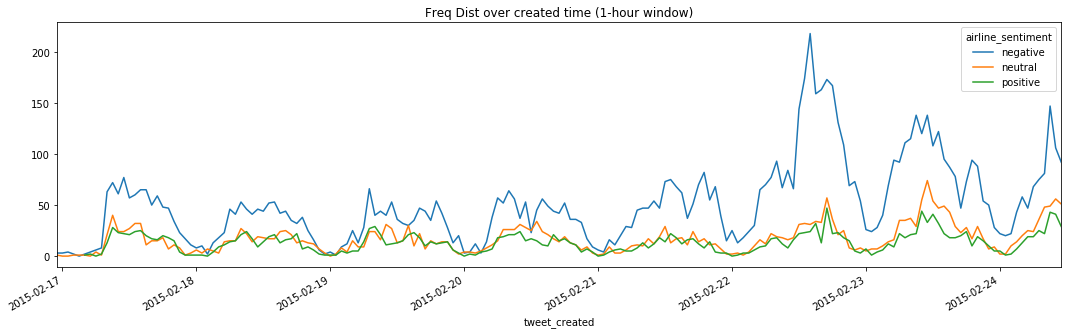

In [34]:
plot_time_series_trend(tweets, 'airline_sentiment', hour_window=1)

Plot tweet count distribution over time for each sentiment type and airline

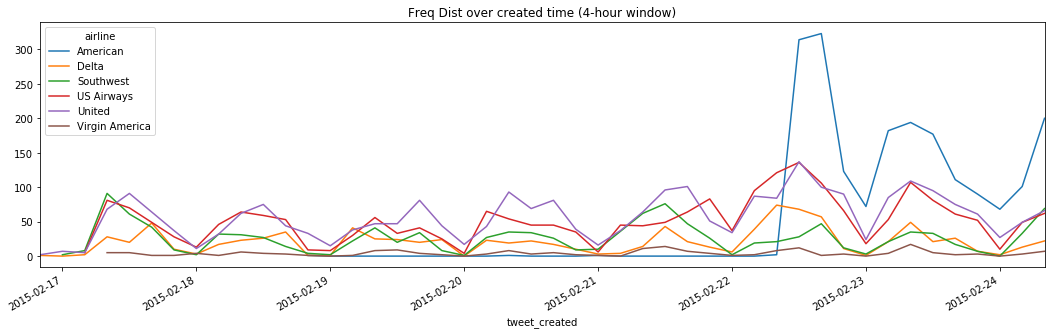

In [35]:
plot_time_series_trend(tweets[tweets['airline_sentiment']=='negative'], 'airline')

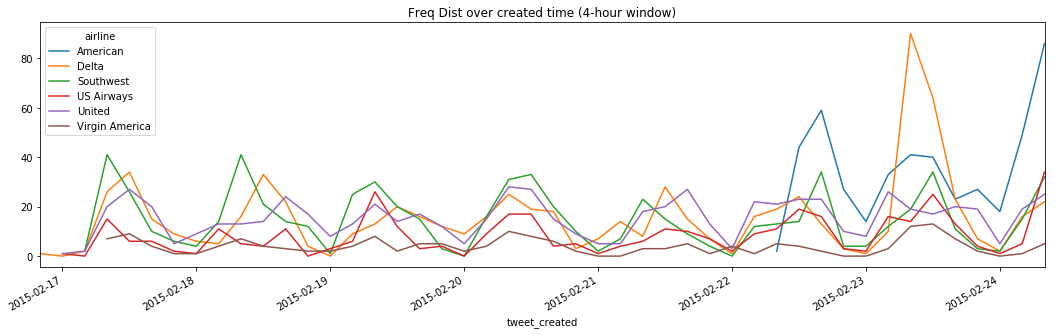

In [36]:
plot_time_series_trend(tweets[tweets['airline_sentiment']=='neutral'], 'airline')

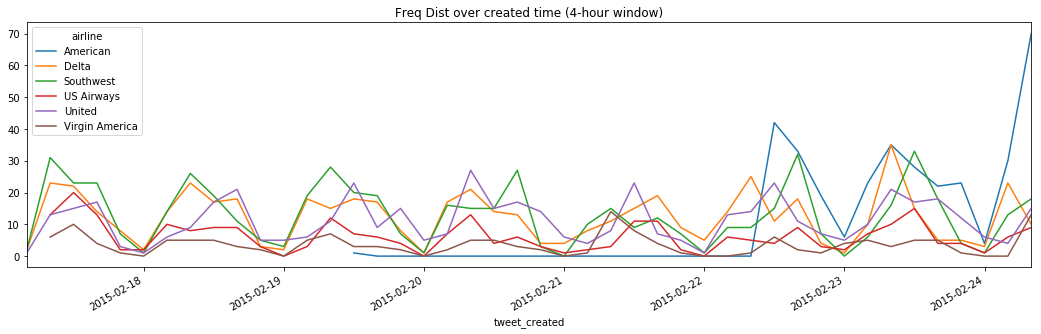

In [37]:
plot_time_series_trend(tweets[tweets['airline_sentiment']=='positive'], 'airline')

Plot distribution for the top 5 most frequent (non-null) user_timezone

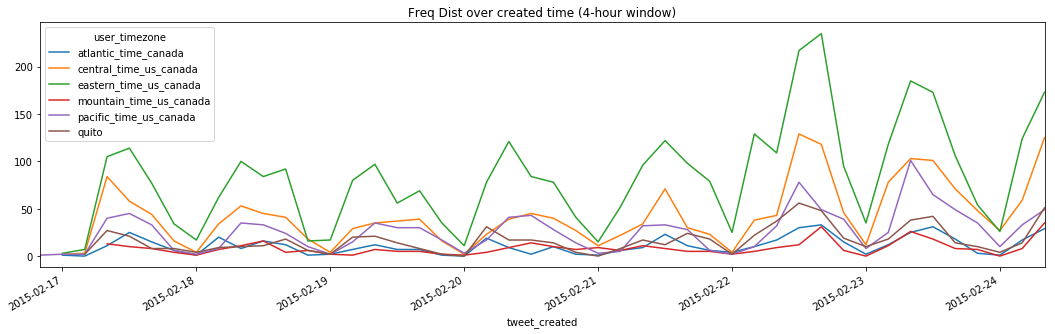

In [38]:
plot_time_series_trend(tweets[tweets['user_timezone'].isin( \
    tweets[tweets['user_timezone'].notnull()]['user_timezone'].value_counts().nlargest(6).index)], 
                       'user_timezone')

#### Conclusion of tweet distribution figures

1. There is stable trend for each date, which goes up for the first half day and generally goes down until midnight. But on 2015-02-22 there is a dramatic rise. 
2. On 2015-02-22, for all types of tweets, American airline is more talked about. Very interesting thing is neutral tweets of Delta increases drasticly on 2015-02-23. However tweet distribution of the other 4 airlines shows a much more stable trend.
3. Generally, people share their flight experiences more often when the there are high range of flight changes/cancels, which is related to many factors. For example, weather changes, accidents, etc. 
4. Since there are only 9 days of data, it's not wise to combine this time series into model. It's not possible to catch time-lag/seasonal trend, and it will overfit on the data rather than tweets in real world.
5. However, as mentioned, because there is stable trend of each individual day, I'd like to take it into consideration.

Slice the day into window of hours and perform chi-squared test:

In [39]:
def slice_time_window(data, column='tweet_created', window=4):
    fmt=lambda x: "{:02d}".format(x)
    slices=24//window
    window_mapping=dict([(i*window+j, fmt(i*window)+'-'+fmt((i+1)*window%24)) 
                         for i in range(slices) 
                         for j in range(window)])
    return data[column].map(lambda x: window_mapping[x.hour])

In [40]:
tweets['tweet_created_time_window']=slice_time_window(tweets)

Performing chi squared test:
significance level: 0.050000000000000044
degree of freedom: 10
chi-squared statistcs is 0.000659543314156721

stat calculated from contigency table is: 65.90208591428267
stat is larger than the chi-squared stat, reject H0. 
	--> Feature tweet_created_time_window and airline_sentiment are dependent

p-value calculated is: 2.7232725754712966e-10
p-value is smaller than aignificance level, reject H0. 
	--> Feature tweet_created_time_window and airline_sentiment are dependent


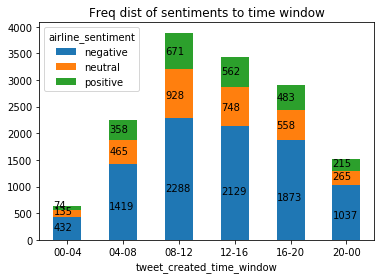

In [41]:
table=chi_squared_test(tweets, 'tweet_created_time_window')
ax=table.sort_index().plot(kind='bar', stacked=True, rot=0, title='Freq dist of sentiments to time window')
for p in ax.patches:
    ax.annotate("{0:.0f}".format(p.get_height()), (p.get_x(), p.get_y()+.4*p.get_height()))
plt.show()

As the report shows, the feature and the target are dependent. So it should be considered as a valid feature

### 1.2.2 Check tweet_location and user_timezone

Perform chi-squared test:

Performing chi squared test:
significance level: 0.050000000000000044
degree of freedom: 5084
chi-squared statistcs is 0.0

stat calculated from contigency table is: 7340.591779699671
stat is larger than the chi-squared stat, reject H0. 
	--> Feature tweet_location and airline_sentiment are dependent

p-value calculated is: 5.636864401140288e-87
p-value is smaller than aignificance level, reject H0. 
	--> Feature tweet_location and airline_sentiment are dependent


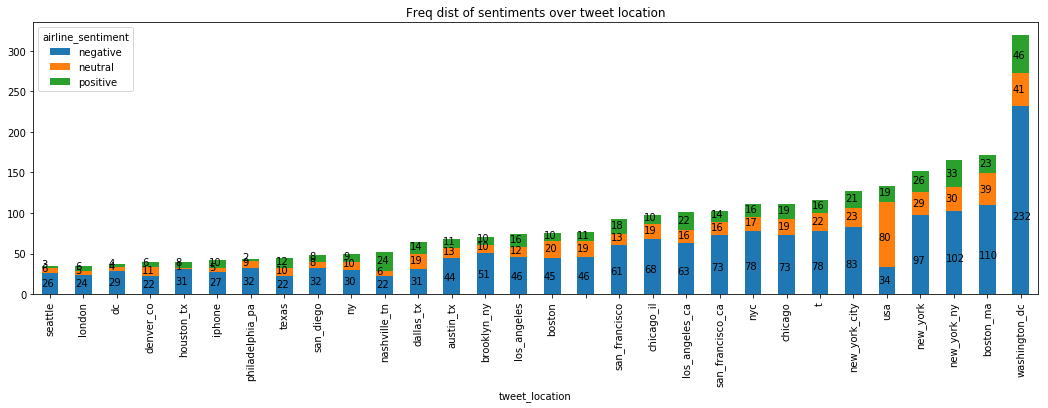

In [42]:
table=chi_squared_test(tweets, 'tweet_location')
ax=table[-30:].plot(figsize=(18, 5), kind='bar', stacked=True, title='Freq dist of sentiments over tweet location')
for p in ax.patches:
    ax.annotate("{0:.0f}".format(p.get_height()), (p.get_x(), p.get_y()+.4*p.get_height()))
plt.show()

Performing chi squared test:
significance level: 0.050000000000000044
degree of freedom: 168
chi-squared statistcs is 1.1538385325157771e-152

stat calculated from contigency table is: 492.95245253954056
stat is larger than the chi-squared stat, reject H0. 
	--> Feature user_timezone and airline_sentiment are dependent

p-value calculated is: 1.134895879260236e-33
p-value is smaller than aignificance level, reject H0. 
	--> Feature user_timezone and airline_sentiment are dependent


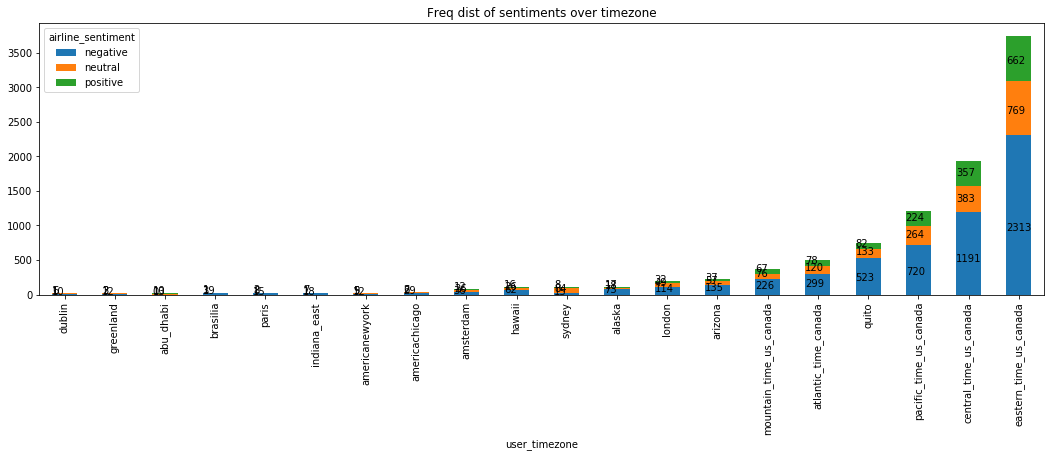

In [43]:
table=chi_squared_test(tweets, 'user_timezone')
ax=table[-20:].plot(figsize=(18, 5), kind='bar', stacked=True, title='Freq dist of sentiments over timezone')
for p in ax.patches:
    ax.annotate("{0:.0f}".format(p.get_height()), (p.get_x(), p.get_y()+.4*p.get_height()))
plt.show()

#### Conclusion
columns user_timezone and tweet_location are dependent and column airline_sentiment are dependent. 

So we will consider imputing the data for these two feaures when modeling, but the approach depends. 

Here are some general approaches:

Approach 1, some learning methods actually can function with missing data; they can handle the missing data, allow for multiple reasoning paths, and/or have their own way of 'filling' in data. In this case, you don't have to do anything.

Approach 2. Do a quick statistical analysis, like mode and place the value that appears most often. It introduces some bias, but, absence of any other information, it does provide the 'most likely' answer.

Approach 3 is what the previous authors have mentioned. You can implement a classifier to 'predict' the missing values. Make sure you do not include the 'class' variable (the one you ultimately want to predict) in the 'missing value' classifier. So, if you have 5 attribute, and want to predict the 5th, then you can use attributes 1, 2, and 4 to try to predict the 3rd variable. Then, once you have replaced the missing values, you then use 1 - 4 to predict 5.

### 1.2.3 Explore retweet_count

First of all, sentiment of tweet and retweet_count can be causal -- an appealing tweet can be retweeted more often. But they are simply not the case on the contrast. So the column will not be in use in modeling.

But we can still have a look at the visualization

In [44]:
tweets['retweet_count'].value_counts()

0     13873
1       640
2        66
3        22
4        17
5         5
7         3
6         3
22        2
8         1
32        1
9         1
31        1
18        1
15        1
28        1
44        1
11        1
Name: retweet_count, dtype: int64

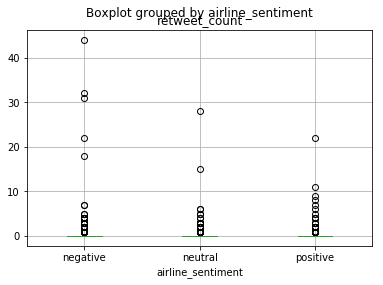

In [45]:
tweets.boxplot('retweet_count', by='airline_sentiment')

As expected, negative tweets are retweeted more often

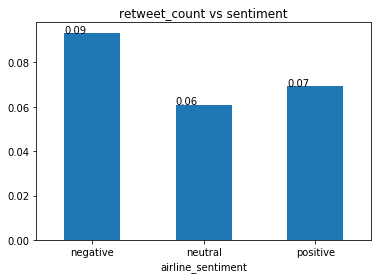

In [46]:
ax=tweets.groupby('airline_sentiment')['retweet_count'].mean().plot.bar(rot=0, title='retweet_count vs sentiment')
for p in ax.patches:
    ax.annotate("{0:.2f}".format(p.get_height()), (p.get_x(), p.get_height()))
plt.show()

### 1.2.4 Meta features of column text

Besides tokenizing the text column, I think the manufactured meta features could also be useful. 

The meta features are all numeric and come from the text column.

I also calculated the Afinn lexicon score for each tweet.

In [47]:
afinn=Afinn()
transform_functions = {
    "score": afinn.score,
    "len": lambda x: len(x),
    "count_space": lambda x: x.count(" "),
    "count_dot": lambda x: x.count("."),
    "count_!": lambda x: x.count("!"),
    "count_?": lambda x: x.count("?"),
    "count_cap": lambda x: len(re.findall("[A-Z]", x)),
    "letter_per_word": lambda x: len(x) / (x.count(" ") + 1),
    "word_per_sent": lambda x: x.count(" ") / (x.count(".") + 1),
}
meta = {}
for k,func in transform_functions.items():
    meta['meta_'+k]=tweets['text'].map(func)
meta=pd.DataFrame(meta)

In [48]:
meta.head()

,meta_score,meta_len,meta_count_space,meta_count_dot,meta_count_!,meta_count_?,meta_count_cap,meta_letter_per_word,meta_word_per_sent
0,0.0,35,3,1,0,0,3,8.750000,1.50
1,0.0,72,8,4,0,0,2,8.000000,1.60
2,0.0,71,11,3,1,0,5,5.916667,2.75
3,-5.0,126,16,0,0,0,2,7.411765,16.00
4,-2.0,55,9,0,0,0,2,5.500000,9.00


In [49]:
meta.describe()

,meta_score,meta_len,meta_count_space,meta_count_dot,meta_count_!,meta_count_?,meta_count_cap,meta_letter_per_word,meta_word_per_sent
count,14640.000000,14640.000000,14640.000000,14640.000000,14640.000000,14640.000000,14640.000000,14640.000000,14640.000000
mean,0.486885,103.822063,16.795492,1.304918,0.362842,0.319536,5.917008,6.047798,9.312504
std,2.867065,36.277339,6.943015,1.370172,0.919708,0.661058,4.934437,1.112110,6.147637
min,-18.000000,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.500000,0.166667
25%,-1.000000,77.000000,12.000000,0.000000,0.000000,0.000000,3.000000,5.346154,5.000000
50%,0.000000,114.000000,18.000000,1.000000,0.000000,0.000000,5.000000,5.818182,7.666667
75%,2.000000,136.000000,22.000000,2.000000,0.000000,1.000000,8.000000,6.454545,12.000000
max,19.000000,186.000000,35.000000,15.000000,27.000000,11.000000,103.000000,19.000000,31.000000


Next I'm going to test if the meta features and the target sentiment are related.

Plot box plot for each meta feature. Except the first two, the others have a lot of outliers

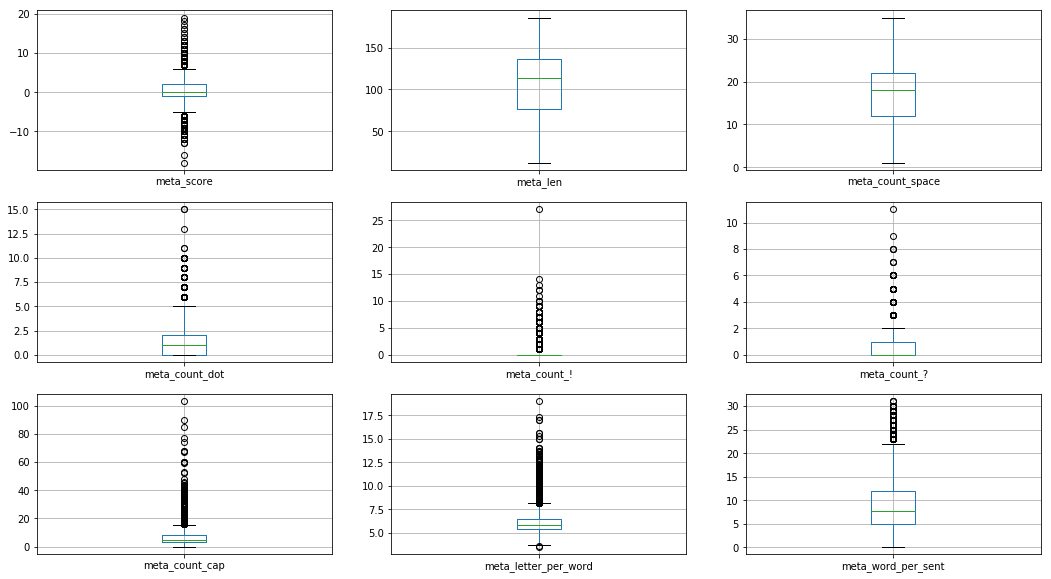

In [50]:
fig = plt.figure(figsize=(18,10))

for i in range(meta.shape[1]):
    fig.add_subplot(3,3,i+1)
    meta.boxplot(meta.columns[i])

Plot quantile-quantile (QQ) plot for each meta feature, which determines whether the data is normally distributed. Comparing my data with the line, except afinn score, none of them really fits, which means they are not from a nomal distribution.

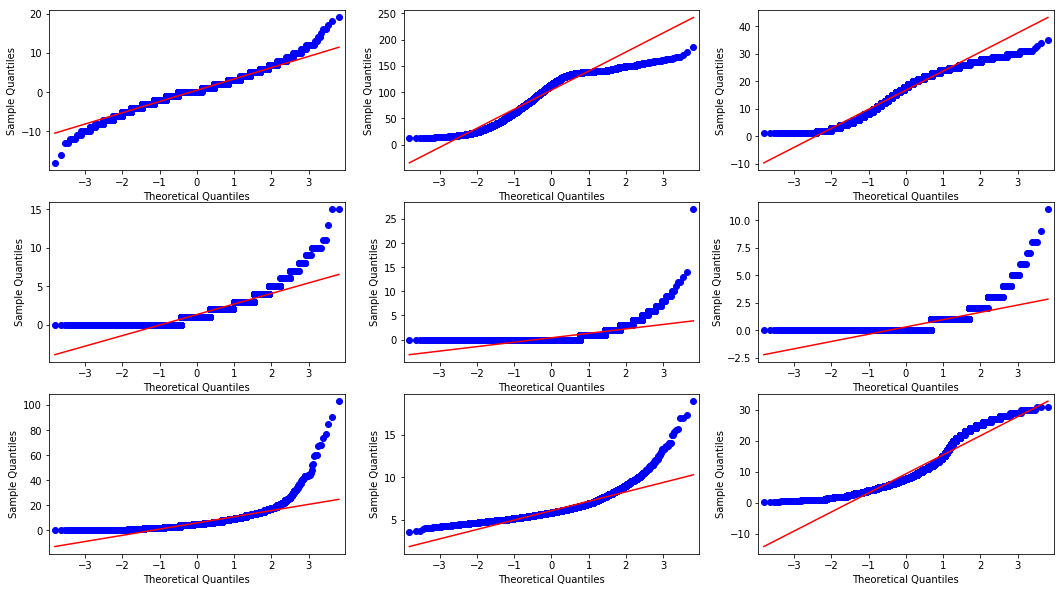

In [51]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18,10))
ax=axes.flatten()
for i in range(meta.shape[1]):
    sm.qqplot(meta.iloc[:, i], line='s', ax=ax[i])

Without the assumption that the data are from normal distribution, to check if the hand-made meta features and my target 'airline_sentiment' are related, I should not perform an one-way ANOVA test. Instead I'll perform a Kruskal-Wallis H-test. 

The null hypothesis is H0: the population median of all of the types are equal.

In [52]:
significance_level=0.05
for c in meta.columns:
    print(c)
    _, p=stats.kruskal(meta[tweets['airline_sentiment']=='negative'][c],
                      meta[tweets['airline_sentiment']=='neutral'][c],
                      meta[tweets['airline_sentiment']=='positive'][c])
    if p <= significance_level:
        print('p-value is smaller than aignificance level \n\t--> reject H0')
    else:
        print('p-value is larger than significance level \n\t--> fail to reject H0')

meta_score
p-value is smaller than aignificance level 
	--> reject H0
meta_len
p-value is smaller than aignificance level 
	--> reject H0
meta_count_space
p-value is smaller than aignificance level 
	--> reject H0
meta_count_dot
p-value is smaller than aignificance level 
	--> reject H0
meta_count_!
p-value is smaller than aignificance level 
	--> reject H0
meta_count_?
p-value is smaller than aignificance level 
	--> reject H0
meta_count_cap
p-value is smaller than aignificance level 
	--> reject H0
meta_letter_per_word
p-value is smaller than aignificance level 
	--> reject H0
meta_word_per_sent
p-value is smaller than aignificance level 
	--> reject H0


Given significance level 0.05, all H0 are rejected. So for each feature, population of each type has different median -- each meta feature helps differ the sentiment type. These features can be considered in modeling.

I explored a bit on the afinn score. Afinn score sums up the sentimental score of each word, positive words have positive scores and negative words have negative scores. 

In our case, tweets with score < 0 are almost aligned with the target sentiment class. But the ones with score >= 0 are not that aligned.

In [53]:
pd.DataFrame({'>0':tweets[meta['meta_score']>0]['airline_sentiment'].value_counts(),
              '=0':tweets[meta['meta_score']==0]['airline_sentiment'].value_counts(),
              '<0':tweets[meta['meta_score']<0]['airline_sentiment'].value_counts()
             })

,>0,=0,<0
negative,3084,2047,4047
neutral,1491,1235,373
positive,2025,247,91


Let's take a look at some examples and see why:

In [54]:
print('meta_score>0 but sentiment is actually negative:\n')
df=pd.DataFrame([meta['meta_score'], tweets['airline_sentiment']]).T
index=df[df.apply(lambda x: x['meta_score']>0 and x['airline_sentiment']=='negative',1)].index
print('\n'.join([str(i[0])+': '+i[1] for i in zip(df.iloc[index]['meta_score'].tolist(), 
                                                  tweets.iloc[index]['text'].tolist())][:10]))

meta_score>0 but sentiment is actually negative:

2.0: @VirginAmerica  I flew from NYC to SFO last week and couldn't fully sit in my seat due to two large gentleman on either side of me. HELP!
1.0: @VirginAmerica What happened 2 ur vegan food options?! At least say on ur site so i know I won't be able 2 eat anything for next 6 hrs #fail
4.0: @VirginAmerica amazing to me that we can't get any cold air from the vents. #VX358 #noair #worstflightever #roasted #SFOtoBOS
1.0: @VirginAmerica help, left expensive headphones on flight 89 IAD to LAX today. Seat 2A. No one answering L&amp;F number at LAX!
4.0: @VirginAmerica Hey, first time flyer next week - excited! But I'm having a hard time getting my flights added to my Elevate account. Help?
3.0: @VirginAmerica hi! i'm so excited about your $99 LGA-&gt;DAL deal- but i've been trying 2 book since last week &amp; the page never loads. thx!
2.0: @VirginAmerica I called a 3-4 weeks ago about adding 3 flights from 2014 to my Elevate...they still 

## 1.3 More visualizations and explorations

Plot the pir chart of the overall sentiments. Sentiment is overall skewed to negative. Usually people care more about negative tweets when comes to new dta. But without given a context of the problem, the model should try to predict each and every type. I'll continue with the original types rather than combine positionve and neutral.

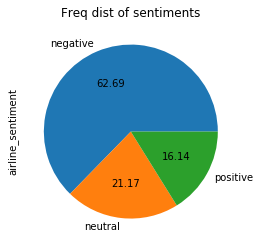

In [55]:
tweets['airline_sentiment'].value_counts().plot(kind='pie', autopct='%.2f', title='Freq dist of sentiments')
plt.show()

Except Virgin America (least) and United (most), the other airlines are quite balanced

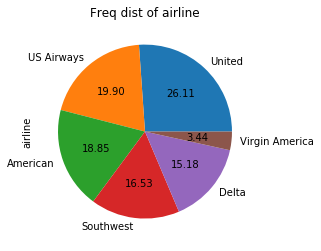

In [56]:
tweets['airline'].value_counts().plot(kind='pie',autopct='%.2f', title='Freq dist of airline')
plt.show()

Sentiment distribution of United, US Airways and American airlines are obviously more skewed to negative than the other three.

Performing chi squared test:
significance level: 0.050000000000000044
degree of freedom: 10
chi-squared statistcs is 0.000659543314156721

stat calculated from contigency table is: 1154.0284059890807
stat is larger than the chi-squared stat, reject H0. 
	--> Feature airline and airline_sentiment are dependent

p-value calculated is: 1.1843123973767377e-241
p-value is smaller than aignificance level, reject H0. 
	--> Feature airline and airline_sentiment are dependent


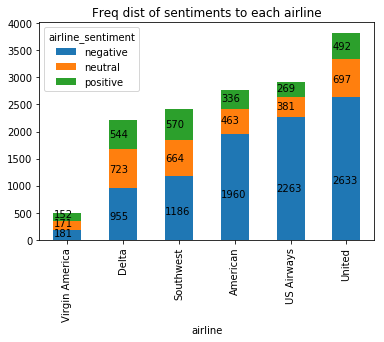

In [57]:
table=chi_squared_test(tweets, 'airline')
ax=table.plot(kind='bar', stacked=True, title='Freq dist of sentiments to each airline')
for p in ax.patches:
    ax.annotate("{0:.0f}".format(p.get_height()), (p.get_x(), p.get_y()+.4*p.get_height()))
plt.show()

Perform chi-squared test and the result shows the negativereason and airline are dependent

In [58]:
table=chi_squared_test(tweets, 'negativereason', 'airline')

Performing chi squared test:
significance level: 0.050000000000000044
degree of freedom: 45
chi-squared statistcs is 1.460511060770192e-28

stat calculated from contigency table is: 520.845891576454
stat is larger than the chi-squared stat, reject H0. 
	--> Feature negativereason and airline are dependent

p-value calculated is: 3.1407034482820173e-82
p-value is smaller than aignificance level, reject H0. 
	--> Feature negativereason and airline are dependent


The top 3 complained reasons are:

Customer Service Issue,
Late Flight,
Can't Tell

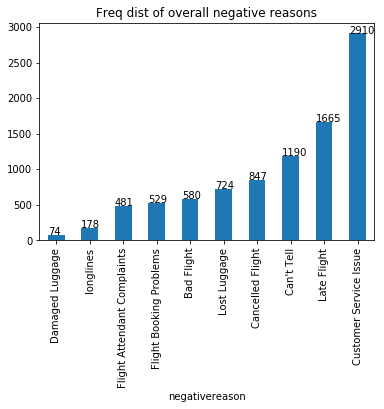

In [59]:
ax=table.sum(1).plot(kind='bar', title='Freq dist of overall negative reasons')
for p in ax.patches:
    ax.annotate("{0:.0f}".format(p.get_height()), (p.get_x(), p.get_height()))
plt.show()

Plot percentage dist of airline of each negative reason. Of all 6 airlines, 

Customer Service is most complained of American
<br>
Late Flight and other ambiguous reasions are most complained of Delta
<br>
Bad Flight and Booking Problems are most complained of Virgin
<br>
The other negative reasons are complained relatively evenly

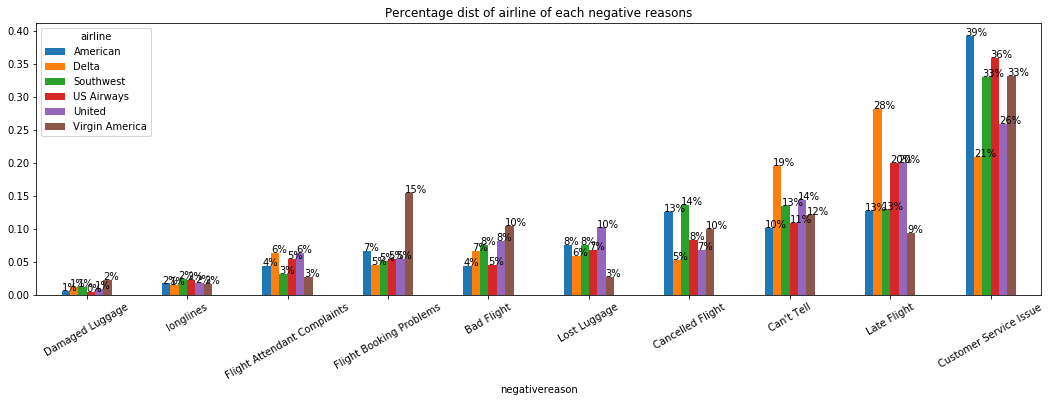

In [60]:
ax=(table/table.sum(0)).plot(kind='bar', figsize=(18,5), rot=30, 
                             title='Percentage dist of airline of each negative reasons')
for p in ax.patches:
    ax.annotate("{0:.0f}%".format(p.get_height()*100), (p.get_x(), p.get_height()))
plt.show()

Plot the distribution of each negative reason for each airline

Except that Delta is most complained about Late Flight, all other airlines are most complained about Customer Service.

In [61]:
table.loc['total', :]=table.sum(0)
table=table.T.sort_values('total')
table=table.loc[:, table.columns!='total']

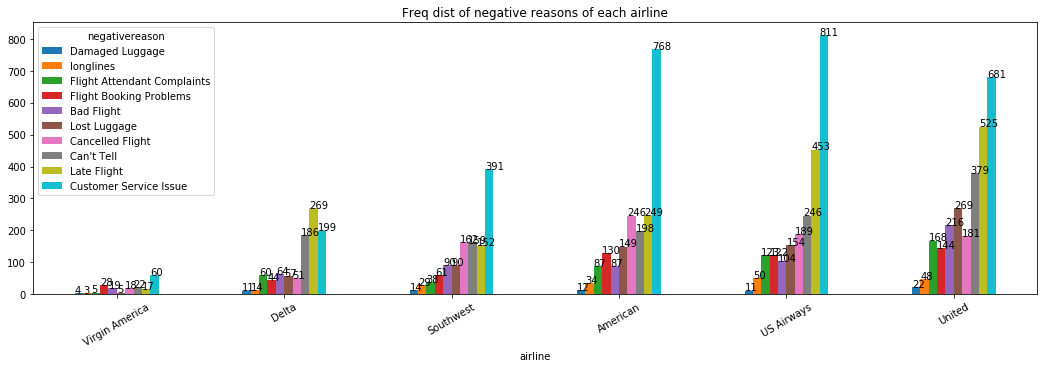

In [62]:
ax=table.plot(kind='bar', figsize=(18,5), rot=30, 
                             title='Freq dist of negative reasons of each airline')
for p in ax.patches:
    ax.annotate("{0:.0f}".format(p.get_height()), (p.get_x(), p.get_height()))
plt.show()

Here follows some examples of the top 3 negative reasons

In [63]:
negative_tweets=tweets[tweets['airline_sentiment']=='negative']

In [64]:
negative_tweets[negative_tweets['negativereason']=="Customer Service Issue"]['text'].head().tolist()

['@VirginAmerica you guys messed up my seating.. I reserved seating with my friends and you guys gave my seat away ... 😡 I want free internet',
 "@VirginAmerica status match program.  I applied and it's been three weeks.  Called and emailed with no response.",
 '@VirginAmerica help, left expensive headphones on flight 89 IAD to LAX today. Seat 2A. No one answering L&amp;F number at LAX!',
 '@VirginAmerica awaiting my return phone call, just would prefer to use your online self-service option :(',
 '@VirginAmerica Your chat support is not working on your site: http://t.co/vhp2GtDWPk']

In [65]:
negative_tweets[negative_tweets['negativereason']=="Late Flight"]['text'].head().tolist()

['@VirginAmerica SFO-PDX schedule is still MIA.',
 "@VirginAmerica Hi, Virgin! I'm on hold for 40-50 minutes -- are there any earlier flights from LA to NYC tonight; earlier than 11:50pm?",
 "@VirginAmerica you're the best!! Whenever I (begrudgingly) use any other airline I'm delayed and Late Flight :(",
 '@VirginAmerica just landed in LAX, an hour after I should of been here. Your no Late Flight bag check is not business travel friendly #nomorevirgin',
 '@VirginAmerica why must a traveler miss a flight to Late Flight check a bag?  I missed my morning appointments and you lost my business. #sfo2lax']

In [66]:
negative_tweets[negative_tweets['negativereason']=="Can't Tell"]['text'].head().tolist()

["@VirginAmerica and it's a really big bad thing about it",
 "@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA",
 '@VirginAmerica why are your first fares in May over three times more than other carriers when all seats are available to select???',
 "@VirginAmerica What happened 2 ur vegan food options?! At least say on ur site so i know I won't be able 2 eat anything for next 6 hrs #fail",
 '@VirginAmerica I have no interesting flying with you after this. I will Cancelled Flight my next four flights I planned.#neverflyvirginforbusiness']

Here are some of my observation while looking at the tweets:

Besides the regular text, there exist emoji, '@' mentions, '#' hashtags, url and html escaping characters like '&amp;'. My idea is to convert emoji to its representing string expression and remove the other observations.

save to csv

In [67]:
df=tweets[['airline_sentiment',
           'text',
           'airline',
           'tweet_created_time_window',
           'user_timezone',
           'tweet_location',]].copy(deep=True)
df.rename(columns={'airline_sentiment':'sentiment',
                   'airline':'tweet_airline',
                   'user_timezone':'tweet_user_timezone'}, inplace=True)
df=df.join(meta)
df.to_csv('Tweets_EDA.csv')